# Cистемы прогнозирования качества молока и объем удоя коров для покупки их молочному хозяйству «Вольный луг»

содержание

_____
_____
## Описание

Молочное хозяйство «Вольный луг», ориентированное на расширение поголовья коров, заключило контракт с ассоциацией пастбищ «ЭкоФерма». Фермер стремится создать стабильное и высококачественное стадо, отбирая бурёнок, которые не только обеспечат высокий удой, но и удовлетворят строгим требованиям к вкусовым качествам молока. Для этого требуется система, которая поможет автоматизировать процесс отбора, снижая риски и обеспечивая объективность в принятии решения.

- Цели и задачи проекта:

    - Прогнозирование удоя коровы: Разработка модели машинного обучения, которая на основе данных о корове (возраст, порода, физическое состояние, рацион, генетика и т.д.) будет прогнозировать её потенциальный удой за год. Модель должна обеспечивать точность предсказания с учётом различных факторов, влияющих на продуктивность.

    - Оценка качества молока:
    Вторая модель будет прогнозировать вероятность того, что молоко от данной коровы будет соответствовать требованиям фермерского хозяйства по вкусовым качествам. Это может включать параметры, такие как жирность молока, соотношение белков и жиров, а также вкусовые характеристики, оцененные по шкале фермером.

    - Критерии отбора коров:
    Для фермерского хозяйства критически важно, чтобы каждая покупаемая бурёнка:
        - Обеспечивала удой не менее 6000 кг молока в год.
        - Производила молоко, соответствующее строгим критериям вкуса.

_____
_____
## Импорт и подготовка к работе

In [1]:
# %pip install bidict
# %pip install phik

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error
from sklearn.preprocessing import LabelEncoder
import shap
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from bidict import bidict
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from plotly.colors import find_intermediate_color, hex_to_rgb
from phik import resources
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from itertools import cycle

c:\Users\bezgr\STUDY\DS\Ya-Practicum\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
pd.set_option('display.max_columns', None)

_____
_____
## Загрузка данных, общая информация и первичная обработка

_____
### Скачивание датасетов и общая информация

1. **```ferma_main.csv```**

|Поле            |Описание                                                           |
|----------------|-------------------------------------------------------------------|
|id              |Уникальный идентификатор коровы                                    |
|Удой, кг        |Масса молока, которую корова даёт в год (в килограммах)            |
|ЭКЕ             |Показатель питательности корма коровы                              |
|Сырой протеин, г|Содержание сырого протеина в корме (в граммах)                     |
|СПО             |Отношение сахара к протеину в корме коровы                         |
|Порода          |Порода коровы                                                      |
|Тип пастбища    |Ландшафт лугов, на которых паслась корова                          |
|порода папы_быка|Порода папы коровы                                                 |
|Жирность, %     |Содержание жиров в молоке (в процентах)                            |
|Белок, %        |Содержание белков в молоке (в процентах)                           |
|Вкус молока     |Оценка вкуса молока по личным критериям фермера (вкусно, не вкусно)|
|Возраст         |Возраст коровы (менее 2 лет, более 2 лет)                          |

In [4]:
ferma = pd.read_csv('ferma_main.csv', delimiter=';', decimal=',')
display(ferma.head(10))
ferma.info()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет
5,6,5254,12.7,1806,0.885,РефлешнСоверинг,Холмистое,Соверин,3.13,3.078,вкусно,менее_2_лет
6,7,5910,13.2,1792,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.48,3.077,вкусно,более_2_лет
7,8,6179,14.7,1806,0.930,Вис Бик Айдиал,Равнинные,Айдиал,3.55,3.076,вкусно,более_2_лет
8,9,6783,14.2,1918,0.940,РефлешнСоверинг,Холмистое,Айдиал,3.71,3.077,вкусно,более_2_лет
9,10,5339,13.4,1791,0.895,Вис Бик Айдиал,Холмистое,Соверин,3.13,3.075,вкусно,менее_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

2. **```ferma_dad.csv```**

|Поле    |Описание                       |
|--------|-------------------------------|
|id      |Уникальный идентификатор коровы|
|Имя Папы|Имя папы коровы                |

In [5]:
dads = pd.read_csv('ferma_dad.csv', delimiter=';')
display(dads.head())
dads.info()

,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


3. **```interested_cows.csv```**

|Поле                   |Описание                                                   |
|-----------------------|-----------------------------------------------------------|
|Порода                 |Порода коровы                                              |
|Тип пастбища           |Ландшафт лугов, на которых паслась корова                  |
|порода папы_быка       |Порода папы коровы                                         |
|Имя_папы               |Имя папы коровы                                            |
|Текущая_жирность,%     |Содержание жиров в молоке (в процентах)                    |
|Текущий_уровень_белок,%|Содержание белков в молоке (в процентах)                   |
|Возраст                |Возраст коровы, бинарный признак (менее_2_лет, более_2_лет)|


In [6]:
interested_cows = pd.read_csv('cow_buy.csv', delimiter=';', decimal=',')
display(interested_cows.head())
interested_cows.info()

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


_____
### Первичная обработка

Объединим датасеты **```dads```** и **```ferma```**

In [7]:
ferma = pd.merge(ferma, dads, on='id', how='left')
ferma.head()

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


_____
### Вывод:

- ```ferma``` (```ferma_main.csv```)
    - Содержит данные о стаде фермера. Включает информацию о коровах, их породах, питании, молочной продуктивности и вкусе молока. Структура данных позволяет анализировать взаимосвязь между кормом, породой, возрастом и качеством молока.
    - Всего 634 строки.
    - Нет пропущенных значений.
    - 3 количественных признака: ```Удой, кг```; ```Сырой протеин, г```; ```Жирность, %```, ```Белок, %```.
    - 9 категориальных признаков: ```ЭКЕ```, ```СПО```, ```Порода```, ```Тип пастбища```, ```Порода папы_быка```, ```Вкус молока```, ```Возраст```.
    - Типы данных верные.
    - Надо переименовать имена столбцов.

- ```dads``` (```ferma_dad.csv```) - Объединил с ```ferma``` по ```id```
    - Хранит имя папы каждой коровы. Этот датасет позволяет связать коров с их отцами для дальнейшего анализа генетических характеристик.
    - Всего 629 строк.
    - Нет пропущенных значений.
    - 1 количественный признак: ```id```.
    - 1 категориальный признак: ```Имя Папы```.
    - Типы данных верные.
    - Надо переименовать имена столбцов.

- ```interested_cows``` (```cow_buy.csv```)
    - Содержит данные о коровах, которых фермер планирует купить. Включает информацию о породе, пастбище, кормлении и молочной продуктивности на момент продажи, но без данных о корме и удое.
    - Всего 20 строк.
    - Нет пропущенных значений.
    - 0 количественных признаков.
    - 7 категориальных признаков: ```Порода```, ```Тип пастбища```, ```порода папы_быка```, ```Имя_папы```, ```Текущая_жирность,%```, ```Текущий_уровень_белок,%```, ```Возраст```.
    - Типы данных верные.
    - Надо переименовать имена столбцов.

_____
_____
## Предобработка данных

_____
### Удаление ненужного столбца id

Так как я слил два датасета по ```id```, то этот признак больше не нужен

In [8]:
ferma = ferma.drop('id', axis=1)
ferma.head()

,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст,Имя Папы
0,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


_____
### Переименовывание столбцов датафреймов

1. **```ferma```**

In [9]:
ferma_columns_translate = bidict({
    'Удой, кг': 'milk_yield',
    'ЭКЕ (Энергетическая кормовая единица)': 'energy_unit',
    'Сырой протеин, г': 'raw_protein',
    'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio',
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'dad_breed',
    'Жирность,%': 'fat_content',
    'Белок,%': 'protein_content',
    'Вкус молока': 'milk_taste',
    'Возраст': 'age',
    'Имя Папы': 'dad_name'
})

ferma = ferma.rename(columns=ferma_columns_translate)
ferma.head()

,milk_yield,energy_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content,protein_content,milk_taste,age,dad_name
0,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет,Буйный
1,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет,Соловчик
2,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет,Барин
3,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет,Буйный
4,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет,Барин


|Поле               |Описание                                                           |
|-----------------  |-------------------------------------------------------------------|
|milk_yield         |Масса молока, которую корова даёт в год (в килограммах)            |
|energy_unit        |Показатель питательности корма коровы                              |
|raw_protein        |Содержание сырого протеина в корме (в граммах)                     |
|sugar_protein_ratio|Отношение сахара к протеину в корме коровы                         |
|breed              |Порода коровы                                                      |
|pasture_type       |Ландшафт лугов, на которых паслась корова                          |
|dad_breed          |Порода папы коровы                                                 |
|fat_content        |Содержание жиров в молоке (в процентах)                            |
|protein_content    |Содержание белков в молоке (в процентах)                           |
|milk_taste         |Оценка вкуса молока по личным критериям фермера (вкусно, не вкусно)|
|age                |Возраст коровы (менее 2 лет, более 2 лет)                          |
|dad_name           |Имя папы коровы                                                    |

2. **```interested_cows```**

In [10]:
interested_cows_columns_translate = bidict({
    'Порода': 'breed',
    'Тип пастбища': 'pasture_type',
    'порода папы_быка': 'dad_breed',
    'Имя_папы': 'dad_name',
    'Текущая_жирность,%': 'fat_content',
    'Текущий_уровень_белок,%': 'protein_content',
    'Возраст': 'age'
})

interested_cows = interested_cows.rename(columns=interested_cows_columns_translate)
interested_cows.head()

,breed,pasture_type,dad_breed,dad_name,fat_content,protein_content,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


|Поле                   |Описание                                  |
|-----------------------|------------------------------------------|
|breed                  |Порода коровы                             |
|pasture_type           |Ландшафт лугов, на которых паслась корова |
|dad_breed              |Порода папы коровы                        |
|dad_name               |Имя папы коровы                           |
|current_fat_content    |Содержание жиров в молоке (в процентах)   |
|current_protein_content|Содержание белков в молоке (в процентах)  |
|age                    |Возраст коровы (менее 2 лет, более 2 лет) |

_____
### Обработка дубликатов

- ***Явные***

1. **```ferma```**

In [11]:
print('Кол-во явных дубликатов:', ferma.duplicated().sum())
ferma = ferma.drop_duplicates()

Кол-во явных дубликатов: 5


2. **```interested_cows```**

In [12]:
print('Кол-во явных дубликатов:', interested_cows.duplicated().sum())
interested_cows = interested_cows.drop_duplicates()

Кол-во явных дубликатов: 4


- ***Неявные***

1. **```ferma```**

In [13]:
for categorical_col in ferma.select_dtypes(include='object').columns:
    print(f'Уникальные значения {categorical_col:<12}\t:\t{ferma[categorical_col].unique()}')

Уникальные значения breed       	:	['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения pasture_type	:	['Равнинное' 'Равнинные' 'Холмистое']
Уникальные значения dad_breed   	:	['Айдиал' 'Соверин' 'Айдиалл']
Уникальные значения milk_taste  	:	['вкусно' 'не вкусно']
Уникальные значения age         	:	['более_2_лет' 'менее_2_лет']
Уникальные значения dad_name    	:	['Буйный' 'Соловчик' 'Барин' 'Геркулес']


- В столбце ```dad_breed``` есть неявный дубликат ("Айдиал" и "Айдиалл")

In [14]:
ferma.dad_breed = ferma.dad_breed.replace('Айдиалл', 'Айдиал')
print(f'Уникальные значения dad_breed: {ferma.dad_breed.unique()}')

Уникальные значения dad_breed: ['Айдиал' 'Соверин']


- В столбце ```pasture_type``` есть неявный дубликат ("Равнинное" и "Равнинные")

In [15]:
ferma.pasture_type = ferma.pasture_type.replace('Равнинные', 'Равнинное')
print(f'Уникальные значения pasture_type: {ferma.pasture_type.unique()}')

Уникальные значения pasture_type: ['Равнинное' 'Холмистое']


2. **```interested_cows```**

In [16]:
for categorical_col in interested_cows.select_dtypes(include='object').columns:
    print(f'Уникальные значения {categorical_col:<12}\t:\t{interested_cows[categorical_col].unique()}')

Уникальные значения breed       	:	['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения pasture_type	:	['холмистое' 'равнинное']
Уникальные значения dad_breed   	:	['Айдиал' 'Соверин']
Уникальные значения dad_name    	:	['Геркулес' 'Буйный' 'Барин' 'Соловчик']
Уникальные значения age         	:	['более_2_лет' 'менее_2_лет']


Неявные дубликаты отсутствуют

3. **```interested_cows```** + **```ferma```**

In [17]:
print('ferma:')
for categorical_col in ferma.select_dtypes(include='object').columns:
    print(f'Уникальные значения {categorical_col:<12}\t:\t{ferma[categorical_col].unique()}')
print('\n\ninterested_cows:')
for categorical_col in interested_cows.select_dtypes(include='object').columns:
    print(f'Уникальные значения {categorical_col:<12}\t:\t{interested_cows[categorical_col].unique()}')

ferma:
Уникальные значения breed       	:	['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения pasture_type	:	['Равнинное' 'Холмистое']
Уникальные значения dad_breed   	:	['Айдиал' 'Соверин']
Уникальные значения milk_taste  	:	['вкусно' 'не вкусно']
Уникальные значения age         	:	['более_2_лет' 'менее_2_лет']
Уникальные значения dad_name    	:	['Буйный' 'Соловчик' 'Барин' 'Геркулес']


interested_cows:
Уникальные значения breed       	:	['Вис Бик Айдиал' 'РефлешнСоверинг']
Уникальные значения pasture_type	:	['холмистое' 'равнинное']
Уникальные значения dad_breed   	:	['Айдиал' 'Соверин']
Уникальные значения dad_name    	:	['Геркулес' 'Буйный' 'Барин' 'Соловчик']
Уникальные значения age         	:	['более_2_лет' 'менее_2_лет']


Хоть датафреймы разные, некоторые их столбцы отвечают за одни признаки, и разные наименования одной категории в разных датафреймах тоже можно считать неявным дубликатом. Если мы занизим все символы в категориальных фичах, то придем к единому именованию.

In [18]:
ferma = ferma.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)
interested_cows = interested_cows.apply(lambda x: x.str.lower() if x.dtype == 'object' else x)

print('ferma:')
for categorical_col in ferma.select_dtypes(include='object').columns:
    print(f'Уникальные значения {categorical_col:<12}\t:\t{ferma[categorical_col].unique()}')
print('\n\ninterested_cows:')
for categorical_col in interested_cows.select_dtypes(include='object').columns:
    print(f'Уникальные значения {categorical_col:<12}\t:\t{interested_cows[categorical_col].unique()}')

ferma:
Уникальные значения breed       	:	['вис бик айдиал' 'рефлешнсоверинг']
Уникальные значения pasture_type	:	['равнинное' 'холмистое']
Уникальные значения dad_breed   	:	['айдиал' 'соверин']
Уникальные значения milk_taste  	:	['вкусно' 'не вкусно']
Уникальные значения age         	:	['более_2_лет' 'менее_2_лет']
Уникальные значения dad_name    	:	['буйный' 'соловчик' 'барин' 'геркулес']


interested_cows:
Уникальные значения breed       	:	['вис бик айдиал' 'рефлешнсоверинг']
Уникальные значения pasture_type	:	['холмистое' 'равнинное']
Уникальные значения dad_breed   	:	['айдиал' 'соверин']
Уникальные значения dad_name    	:	['геркулес' 'буйный' 'барин' 'соловчик']
Уникальные значения age         	:	['более_2_лет' 'менее_2_лет']


_____
### Обработка аномальных значений

1. **```ferma```**

In [19]:
fig = make_subplots(
    rows=2, cols=3,
    vertical_spacing=0.07,
    subplot_titles=[
        ferma_columns_translate.inverse[name] for name in ferma.select_dtypes(include=['number']).columns
    ])

for i, column in enumerate(ferma.select_dtypes(include=['number']).columns):
    fig.add_trace(
        go.Box(y=ferma[column], name=''),
        row=(i // 3) + 1, col=(i % 3) + 1
    )
fig.update_layout(height=1000, width=1000, showlegend=False, title='График "Ящик с усами" для каждой количественной фичи в ferma')

"В среднем, корова может дать от 5 000 до 10 000 литров молока в год в зависимости от породы, рациона и условий содержания. Однако, более продуктивные породы могут достигать удоя до 12 000-15 000 литров в год."
- Выбросом можно считать только значение 45616 в столбце ```Удой, кг``` (```milk_yield```). 

In [20]:
display(ferma[ferma.milk_yield > 15000])
ferma = ferma[ferma.milk_yield < 15000]

,milk_yield,energy_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content,protein_content,milk_taste,age,dad_name
16,45616,11.5,1675,0.93,вис бик айдиал,холмистое,айдиал,3.22,3.076,вкусно,более_2_лет,буйный


- Также математически слишком аномальными можно считать коров, у которых ```Жирность,%``` (```fat_content```) < 3.1

In [21]:
display(ferma[ferma.fat_content < 3.1])
ferma = ferma[ferma.fat_content >= 3.1]

,milk_yield,energy_unit,raw_protein,sugar_protein_ratio,breed,pasture_type,dad_breed,fat_content,protein_content,milk_taste,age,dad_name
17,5777,12.4,1873,0.895,вис бик айдиал,холмистое,айдиал,3.03,3.080,вкусно,более_2_лет,буйный
554,5686,14.7,1712,0.860,рефлешнсоверинг,холмистое,айдиал,3.01,3.074,вкусно,более_2_лет,буйный
558,5346,12.4,1837,0.860,рефлешнсоверинг,холмистое,соверин,3.01,3.078,не вкусно,менее_2_лет,барин
561,5300,13.0,1785,0.860,вис бик айдиал,равнинное,соверин,2.99,3.077,не вкусно,менее_2_лет,соловчик
568,5989,13.2,1721,0.860,вис бик айдиал,холмистое,соверин,2.99,3.076,вкусно,менее_2_лет,соловчик
576,5376,11.7,1825,0.860,рефлешнсоверинг,равнинное,соверин,2.99,3.076,не вкусно,менее_2_лет,соловчик


- Выбросы, которые отображены на графике признака ```Белок,%``` (```protein_content```), трогать не будем, потому что они вполне укладываются в рамки разумного.

2. **```interested_cows```**

In [22]:
fig = make_subplots(
    rows=1, cols=2,
    vertical_spacing=0.07,
    subplot_titles=[
        interested_cows_columns_translate.inverse[name] for name in interested_cows.select_dtypes(include=['number']).columns
    ])

for i, column in enumerate(interested_cows.select_dtypes(include=['number']).columns):
    fig.add_trace(
        go.Box(y=interested_cows[column], name=''),
        row=(i // 3) + 1, col=(i % 3) + 1
    )
fig.update_layout(height=550, width=750, showlegend=False, title='График "Ящик с усами" для каждой количественной фичи в interested_cows')

Выбросов нет.

_____
### Общая обработка данных

- В ```interested_cows``` параметры корма ```ЭКЕ (Энергетическая кормовая единица)```, ```Сырой протеин, г``` и ```СПО (Сахаро-протеиновое соотношение)``` отсутствуют. Технологи заказчика пересмотрели подход к кормлению: для новых коров планируется увеличить значения каждого из этих параметров на 5%. Поэтому добавим эти три признака, взяв данные из ```ferma```.

In [23]:
interested_cows['energy_unit'] = ferma.energy_unit.mean() * 1.05
interested_cows['raw_protein'] = ferma.raw_protein.mean() * 1.05
interested_cows['sugar_protein_ratio'] = ferma.sugar_protein_ratio.mean() * 1.05
interested_cows_columns_translate = bidict({**interested_cows_columns_translate,
                                            **{'ЭКЕ (Энергетическая кормовая единица)': 'energy_unit',
                                               'Сырой протеин, г': 'raw_protein',
                                               'СПО (Сахаро-протеиновое соотношение)': 'sugar_protein_ratio'}})
interested_cows.head()

,breed,pasture_type,dad_breed,dad_name,fat_content,protein_content,age,energy_unit,raw_protein,sugar_protein_ratio
0,вис бик айдиал,холмистое,айдиал,геркулес,3.58,3.076,более_2_лет,15.292862,2021.280386,0.959222
1,вис бик айдиал,равнинное,соверин,буйный,3.54,3.081,менее_2_лет,15.292862,2021.280386,0.959222
2,рефлешнсоверинг,равнинное,соверин,барин,3.59,3.074,более_2_лет,15.292862,2021.280386,0.959222
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.40,3.061,более_2_лет,15.292862,2021.280386,0.959222
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.64,3.074,более_2_лет,15.292862,2021.280386,0.959222


- Также укажем какой класс в категориальном признаке ```milk_taste``` является положительным

In [24]:
ferma.milk_taste = pd.Categorical(ferma.milk_taste, categories=['не вкусно', 'вкусно'], ordered=True)
ferma.milk_taste

0         вкусно
1         вкусно
2      не вкусно
3      не вкусно
4         вкусно
         ...    
624    не вкусно
625       вкусно
626    не вкусно
627       вкусно
628       вкусно
Name: milk_taste, Length: 622, dtype: category
Categories (2, object): ['не вкусно' < 'вкусно']

_____
### Вывод:

- ```ferma```:
    - Кол-во строк в сократилось с 634 до 628.
    - Удален столбец ```id```, из-за дальнейшей ненадобности.
    - Переименованы столбцы на корректные имена.
    - Обработаны дубликаты и аномальные значения.

|Старые имена        |Новые имена          |Описание                                                           |
|--------------------|---------------------|-------------------------------------------------------------------|
|~~id~~              |**-**                |Уникальный идентификатор коровы                                    |
|~~Удой, кг~~        |*milk_yield*         |Масса молока, которую корова даёт в год (в килограммах)            |
|~~ЭКЕ~~             |*energy_unit*        |Показатель питательности корма коровы                              |
|~~Сырой протеин, г~~|*raw_protein*        |Содержание сырого протеина в корме (в граммах)                     |
|~~СПО~~             |*sugar_protein_ratio*|Отношение сахара к протеину в корме коровы                         |
|~~Порода~~          |*breed*              |Порода коровы                                                      |
|~~Тип пастбища~~    |*pasture_type*       |Ландшафт лугов, на которых паслась корова                          |
|~~порода папы_быка~~|*dad_breed*          |Порода папы коровы                                                 |
|~~Жирность, %~~     |*fat_content*        |Содержание жиров в молоке (в процентах)                            |
|~~Белок, %~~        |*protein_content*    |Содержание белков в молоке (в процентах)                           |
|~~Вкус молока~~     |*milk_taste*         |Оценка вкуса молока по личным критериям фермера (вкусно, не вкусно)|
|~~Возраст~~         |*age*                |Возраст коровы (менее 2 лет, более 2 лет)                          |
|**-**               |*dad_name*           |Имя папы коровы                                                    |

- ```interested_cows```:
    - Кол-во строк в сократилось с 20 до 18.
    - Переименованы столбцы на корректные имена.
    - Обработаны дубликаты.
    - Добавлены признаки ```energy_unit```, ```raw_protein```, ```sugar_protein_ratio``` по пересмотренному технологами подходу к кормлению коров

|Старые имена               |Новые имена              |Описание                                      |
|---------------------------|-------------------------|----------------------------------------------|
|~~Порода~~                 |*breed*                  |Порода коровы                                 |
|~~Тип пастбища~~           |*pasture_type*           |Ландшафт лугов, на которых паслась корова     |
|~~порода папы_быка~~       |*dad_breed*              |Порода папы коровы                            |
|~~Имя_папы~~               |*dad_name*               |Имя папы коровы                               |
|~~Текущая_жирность,%~~     |*current_fat_content*    |Содержание жиров в молоке (в процентах)       |
|~~Текущий_уровень_белок,%~~|*current_protein_content*|Содержание белков в молоке (в процентах)      |
|~~Возраст~~                |*age*                    |Возраст коровы (менее 2 лет, более 2 лет)     |
|**-**                      |*energy_unit*            |Показатель питательности корма коровы         |
|**-**                      |*raw_protein*            |Содержание сырого протеина в корме (в граммах)|
|**-**                      |*sugar_protein_ratio*    |Отношение сахара к протеину в корме коровы    |

_____
_____
## Анализ данных

_____
### Функции отрисовок данных

In [25]:
def statistical_graphis_for_categorical(data, hist_title, agg='val_count', top_n_in_pie=5):
    fig = make_subplots(
        rows=1, cols=2, specs=[[{'type': 'xy'}, {'type': 'domain'}]],
        subplot_titles=('Гистограмма', 'Круговая диаграмма')
    )
    if agg == 'val_count':
        category_agg = data.value_counts()
    elif agg == 'sum':
        category_agg = data.sum()
    else:
        raise ValueError('agg="val_count"|sum')
    categories = category_agg.index
    val_agg = category_agg.values

    fig.add_trace(
        go.Bar(
            x=val_agg, y=categories, 
            orientation='h',
            marker_color='green', 
			showlegend=False, 
			name=data.name,
            width=0.8
        ),
        row=1, col=1
    )
    fig.update_xaxes(title_text='Частота' if agg == 'val_count' else 'Сумма', row=1, col=1)
    fig.update_yaxes(title_text=hist_title, tickvals=categories, row=1, col=1)

    other = [category_agg[top_n_in_pie:].sum()]
    fig.add_trace(
        go.Pie(labels=category_agg.head(top_n_in_pie).index.tolist() + (['Остальные'] if other[0] else []),
               values=category_agg.head(top_n_in_pie).values.tolist() + (other if other[0] else []),
               name='',
               textinfo='label+percent'),
        row=1, col=2
    )

    fig.update_layout(
        title_text=f'Статистические графики по колонке <b>{hist_title}</b><br>(<b>{data.name}</b>)',
        title_x=0.5,
        showlegend=True,
        width=1000,
        height=600,
    )

    fig.show()


def statistical_graphis_for_numeric(col: pd.Series, xaxis_title, nbinsx=50):
	fig = make_subplots(rows=1, cols=2, subplot_titles=('Гистограмма', 'Диаграмма размаха'))

	fig.add_trace(
		go.Histogram(x=col, nbinsx=nbinsx, marker_color='blue', name=col.name),
		row=1, col=1
	)
	fig.update_xaxes(title_text=xaxis_title, row=1, col=1)
	fig.update_yaxes(title_text='Частота', row=1, col=1)

	fig.add_trace(
		go.Box(y=col, marker_color='orange', name=''),
		row=1, col=2
	)
	fig.update_yaxes(title_text=xaxis_title, row=1, col=2)

	fig.update_layout(
		title_text=f'Статистические графики по значению <b>{xaxis_title}</b><br>(<b>{col.name}</b>)',
        title_x=0.5,
		showlegend=False,
		width=1000,
		height=500
	)

	fig.show()

_____
### Количественные признаки

In [26]:
for num_col in ferma.select_dtypes(include=[int, float]).columns:
    statistical_graphis_for_numeric(
        col=ferma[num_col],
        xaxis_title=ferma_columns_translate.inverse[num_col],
        nbinsx={'milk_yield': 25,
                'energy_unit': 20,
                'raw_protein': 30,
                'sugar_protein_ratio': 20,
                'fat_content': 10,
                'protein_content': 30}[num_col]
    )

- ```Удой, кг```: Гистограмма описывается нормальным распределением.
- ```ЭКЕ (Энергетическая кормовая единица)```: Гистограмма описывает распределение Пуассона. 
- ```Сырой протеин, г```: Гистограмма имеет нисходящий тренд, что говорит о том что коров с более низким отношением сахара к протеину преимущественно.
- ```СПО (Сахаро-протеиновое соотношение)```: Многомодальное распределение, что может говорить о наличии подгрупп в данных. 
- ```Жирность,%```: Гистограма имеет высходящий тренд, что говорит о том, что коровы с жирным молокос преобладают.
- ```Белок,%```: Гистограмма описывается нормальным распределением, что есть хорошо для количественного признака.

_____
### Категориальные признаки

In [27]:
for cat_col in ferma.select_dtypes(include='object').columns:
    statistical_graphis_for_categorical(ferma[cat_col], hist_title=ferma_columns_translate.inverse[cat_col], top_n_in_pie=5)

- Могу сказать только то, что нет дисбаланса классов категориальных признаков, что есть хорошо.

_____
### Вывод:

- Анализ количественных признаков показал разные типы распределений: нормальное (удой, белок) до пуассоновское (ЭКЕ) и многомодального (СПО). Отмечено преобладание низкого содержания сырого протеина и высокожирного молока, что отражает особенности коров.
- Категориальные признаки сбалансированы по классам, что положительно влияет на дальнейший анализ.
- Возможно стоит обратить внимание на значение СПО, так как оно имеет нестандратное распределение (можно расмотреть возможность написания ансамбля бэггинг).

_____
_____
## Корреляционный анализ признаков

_____
### Матрица корреляции

In [28]:
px.imshow(
    ferma.rename(columns=ferma_columns_translate.inv).phik_matrix(), 
    text_auto='.3f',
    color_continuous_scale='oranges',
    title='Матрица корреляции для <b>ferma</b>'
).update_layout(
    width=1000,
    height=800,
    title_font_size=20,
    font=dict(size=14)
)

interval columns not set, guessing: ['Удой, кг', 'ЭКЕ (Энергетическая кормовая единица)', 'Сырой протеин, г', 'СПО (Сахаро-протеиновое соотношение)', 'Жирность,%', 'Белок,%']


С таргетом ```Удой,кг``` коррелируют:
- 2 признака средне (>0.5): ```СПО (Сахаро-протеиновое соотношение)```, ```порода папы_быка```.
- 3 признаков сильно (>0.7): ```Возраст```, ```ЭКЕ (Энергетическая кормовая единица)```, ```Жирность,%```.

С таргетом ```Вкус молока``` только один признак коррелируют средне: ```СПО (Сахаро-протеиновое соотношение)```.


Следует отметить наличие мультиколлинеарности, к примеру: 
- corr(```Возраст```, ```ЭКЕ...```) = 0.767
- corr(```ЭКЕ...```, ```Жирность,%```) = 0.723
- corr(```Возраст```, ```СПО...```) = 0.672

_____
### Матрица значимости

Эта матрица показывает, какие коэффициенты корреляции являются статистически значимыми.

In [29]:
# px.imshow(
#     ferma.rename(columns=ferma_columns_translate.inv).significance_matrix(), 
#     text_auto='.3f',
#     color_continuous_scale='oranges',
#     title='Матрица значимости для <b>ferma</b>'
# ).update_layout(
#     width=1000,
#     height=800,
#     title_font_size=20,
#     font=dict(size=14)
# )

- Для таргета ```Удой,кг``` все вышесказанные признаки имеют аналогично высокие значения и в матрице значимости, кроме признака ```порода папы_быка```
- Для ```Вкус молока``` признак ```СПО (Сахаро-протеиновое соотношение)``` имеет наибольшую значимость судя, по данной таблице.

_____
### Диаграмма рассеяния с разбиением на категории.

In [30]:
color_palette = cycle(px.colors.qualitative.Plotly)

def draw_scatter_between_milk_yield_ans(num_col, opacity=0.4):

    fig = make_subplots(
        rows=3, cols=2, vertical_spacing=0.09,
        subplot_titles=[ferma_columns_translate.inverse[col] for col in ferma.select_dtypes(include='object').columns]
    )

    for cetegoty_i, category_col in enumerate(ferma.select_dtypes(include='object').columns):
        # Перебор категориальных признаков

        for class_of_category, group_of_category in ferma.groupby(category_col):
            # Перебор по каждому классу категории

            color = next(color_palette)
            x = group_of_category[num_col]
            y = group_of_category['milk_yield']

            # диаграмма рассеяния по классу
            fig.add_trace(
                go.Scatter(
                    x=x,
                    y=y,
                    mode='markers',
                    marker=dict(size=7, opacity=opacity, color=color),
                    name=class_of_category,
                    legendgroup=ferma_columns_translate.inverse[category_col],
                    legendgrouptitle=dict(text=ferma_columns_translate.inverse[category_col]),
                ),
                row=cetegoty_i // 2 + 1, col=cetegoty_i % 2 + 1
            )
            slope, intercept = np.polyfit(x, y, 1)
            trend_line = slope * x + intercept

            # Линия тренда по классу
            fig.add_trace(
                go.Scatter(
                    x=x,
                    y=trend_line,
                    mode='lines',
                    line=dict(
                        color=f'rgb{find_intermediate_color(hex_to_rgb(color), [0] * 3, 0.4)}',
                        width=3
                    ),
                    name='Линия тренда',
                    visible='legendonly',
                    legendgroup=ferma_columns_translate.inverse[category_col],
                ),
                row=cetegoty_i // 2 + 1, col=cetegoty_i % 2 + 1
            )

        # Общая линия тренда
        slope, intercept = np.polyfit(ferma[num_col], ferma.milk_yield, 1)
        trend_line = slope * ferma[num_col] + intercept
        fig.add_trace(
            go.Scatter(
                x=ferma[num_col],
                y=trend_line,
                mode='lines',
                name='Общая линия тренда',
                visible='legendonly',
                line=dict(color='black', width=3),
                legendgroup=ferma_columns_translate.inverse[category_col],
            ),
            row=cetegoty_i // 2 + 1, col=cetegoty_i % 2 + 1
        )
        fig.update_xaxes(title_text=ferma_columns_translate.inverse[num_col], row=cetegoty_i // 2 + 1, col=cetegoty_i % 2 + 1)
        fig.update_yaxes(title_text=ferma_columns_translate.inverse['milk_yield'], row=cetegoty_i // 2 + 1, col=cetegoty_i % 2 + 1)

    title=(f'Диаграммы рассеяния между признаками <b>Удой, кг</b> и <b>{ferma_columns_translate.inverse[num_col]}</b>,' +
           f'<br>разбитые по классам категориальных признаков<br>corr={ferma.milk_yield.corr(ferma[num_col]):.3f}')
    fig.update_layout(
        title=title,
        title_y=0.98,
        title_x=0.5,
        height=1200,
        width=1200,
        legend=dict(
            traceorder='grouped',
            groupclick='toggleitem',
        ),
    )
    fig.show()

- ```energy_unit```

In [31]:
draw_scatter_between_milk_yield_ans('energy_unit', opacity=0.5)

Диаграмма рассеяния выражается квадратичной функцией, однако можно сказать что и линейной тоже. Разбиено по классам заметно только по категории ```Возраст``` (```более_2_лет``` -> больше ```Удой,кг```) и ```порода папа_быка``` (```айдиал``` -> больше ```Удой,кг```). Значение корреляции считается сильным.

- ```raw_protein```

In [32]:
draw_scatter_between_milk_yield_ans('raw_protein', opacity=0.5)

Корреляция считается умеренной, Есть очертание линейной зависимости.

- ```sugar_protein_ratio```

In [33]:
draw_scatter_between_milk_yield_ans('sugar_protein_ratio', opacity=0.3)

Можно наблюдать многомодальное поведение данной переменной, и все же корреляция сильная. Здесь ярко вырожены три группы ($[0.84; 0.86], [0.88; 0.9], [0.93; 0.96]$) => можно рассмотреть возможность перевода признака в категориальный.

- ```fat_content```

In [34]:
draw_scatter_between_milk_yield_ans('fat_content', opacity=0.4)

Значение корреляции хорошее, однако тяжело разглядеть линейную зависимость. Видно, что тоже есть группа коров, у которых жирность молока с отрывом больше остальных.

- ```protein_content```

In [35]:
draw_scatter_between_milk_yield_ans('protein_content', opacity=0.3)

Нулевая корреляция и такая же зависимость.

_____
### Вывод:

- Удой (milk_yield) наиболее сильно коррелирует с ```ЭКЕ (Энергетическая кормовая единица)```, ```Возрастом``` и ```Жирностью,%```. Эти признаки показали значимое влияние на целевой признак.
- Мультиколлинеарность обнаружена между возрастом, ```ЭКЕ (Энергетическая кормовая единица)``` и ```Жирностью,%```.
- Для дальнейшего моделирования выбраны признаки: ```ЭКЕ (Энергетическая кормовая единица)```, ```СПО (Сахаро-протеиновое соотношение)```, ```Сырой протеин, г```, ```порода папы_быка```, ```Жирность,%```, ```Возраст```, ```Тип пастбища```, ```Вкус молока```.

_____
_____
## Модели

_____
### Модель регрессии для предсказания ```Удоя,кг```.

Добавил [RFECV](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.RFECV.html), чтоб точно не прогодать с выбранными фичами.

In [36]:
def get_reg_X_y(columns) -> list[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X = ferma[columns]
    y = ferma.milk_yield
    return train_test_split(X, y, random_state=42)


def get_pipepline_reg(numerical_columns: list[str],
                      categorical_columns: list[str],
                      convertible_columns: dict[str, int] = dict(),
                      func_transformable_columns: dict[str, callable] = dict()) -> Pipeline:
    '''
    Создает пайплайн для модели линейной регрессии.

    Parameters
    ----------
    numerical_columns : list of str
        Список имен числовых колонок, которые необходимо масштабировать.
    categorical_columns : list of str
        Список имен категориальных колонок, которые необходимо закодировать.
    convertible_columns : dict of {str: int}, optional
        Словарь, где ключ — имя числовой переменной, а значение — количество бинов (n_bins),
        если требуется бинирование. Пример: {'sugar_protein_ratio': 3}.
        По умолчанию пустой словарь (бинирование не выполняется).
    func_transformable_columns : dict of {str: callable}, optional
        Словарь, где ключ — имя числовой переменной, а значение — функция для её преобразования,
        которая будет применена через FunctionTransformer. Пример: {'energy_unit': np.square}.
        По умолчанию пустой словарь (функции не применяются).

    Returns
    -------
    pipeline : sklearn.pipeline.Pipeline
        Конвейер, содержащий шаги предобработки данных и обучения модели регрессии.
        Шаги включают:
        - Масштабирование числовых колонок.
        - Кодирование категориальных колонок.
        - Бинирование и кодирование числовых колонок, если указаны в convertible_columns.
        - Преобразование данных через функции, если указаны в func_transformable_columns.
        - Модель с RFECV для отбора признаков и обучения линейной регрессии.
    '''

    numerical_preprocessor = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_preprocessor = Pipeline(
        steps=[('one_hot', OneHotEncoder(handle_unknown='ignore', drop='first')),
               ('scaler', StandardScaler(with_mean=False))]
    )

    transformers = [('numerical', numerical_preprocessor, list(set(numerical_columns) - set(convertible_columns) - set(func_transformable_columns))),
                    ('categorical', categorical_preprocessor, categorical_columns)]

    for column in convertible_columns:
        convertible_preprocessor = Pipeline(
            steps=[('discretizer', KBinsDiscretizer(n_bins=convertible_columns[column], encode='ordinal', strategy='kmeans')),
                   ('one_hot', OneHotEncoder(handle_unknown='ignore', drop='first')),
                   ('scaler', StandardScaler(with_mean=False))]
        )
        transformers.append((f'convertible_{column}', convertible_preprocessor, [column]))
    
    for column in func_transformable_columns:
        func_transformable_preprocessor = Pipeline(
            steps=[('func_transform', FunctionTransformer(func_transformable_columns[column], feature_names_out='one-to-one')),
                   ('scaler', StandardScaler())]
        )
        transformers.append((f'func_transformable_{column}', func_transformable_preprocessor, [column]))

    preprocessor = ColumnTransformer(transformers, verbose_feature_names_out=False)

    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model',
             RFECV(estimator=LinearRegression(n_jobs=2),
                   min_features_to_select=1,
                   step=1,
                   scoring='r2',
                   n_jobs=5,
                   cv=5,
                   verbose=0))
        ]
    )


def rfecv_perfomance(*cv_results, score_names:list[str]):
    fig = go.Figure()
    for i, cv_result in enumerate(cv_results, start=1):
        num_features = np.arange(1, len(cv_result['mean_test_score']) + 1)
        mean_test_scores = cv_result['mean_test_score']
        fig.add_trace(go.Scatter(x=num_features,
                                 y=mean_test_scores,
                                 mode='lines+markers',
                                 name=score_names[i-1],
                                 legendgroup=str(i),
                                 legendgrouptitle=dict(text=f'Версия {i}')))

        max_index = np.argmax(mean_test_scores)
        fig.add_trace(go.Scatter(x=[num_features[max_index]],
                                 y=[mean_test_scores[max_index]],
                                 mode='markers',
                                 marker=dict(color='red', size=10),
                                 showlegend=False,
                                 name=score_names[i-1],
                                 legendgroup=str(i),
                                 legendgrouptitle=dict(text=f'Версия {i}')))

    fig.update_layout(
        title_text=f'Метрики в зависимости от числа признаков',
        xaxis_title='Число признаков',
        yaxis_title='Метрика',
        showlegend=True
    )

    fig.show()


def shap_perfomance(pipeline, X_train, X_test):
    X_train_transformed = pipeline.transform(X_train)
    X_test_transformed = pipeline.transform(X_test)
    final_feature_names = pipeline.get_feature_names_out()

    explainer = shap.Explainer(pipeline.named_steps['model'].estimator_, X_train_transformed, feature_names=final_feature_names)
    shap_values = explainer(X_test_transformed)
    shap.summary_plot(shap_values, X_test_transformed)


def analyze_residuals(model, X_test, y_test, xbins_size=None):
    residuals = y_test - model.predict(X_test)
    mean_residuals = np.mean(residuals)
    fig = make_subplots(rows=2, cols=1, subplot_titles=['Распределение остатков', 'Диаграмма рассеивания'], vertical_spacing=0.1)
    
    fig.add_trace(go.Histogram(x=residuals,
                               xbins=dict(start=min(residuals), end=max(residuals), size=xbins_size),
                               marker=dict(color='green'),
                               name='Гистограмма'),
                  row=1, col=1)
    fig.add_vline(x=0, line_width=2, line_dash='dash', line_color='lightyellow', name='Ноль', row=1, col=1)
    fig.add_vline(x=mean_residuals, line_width=2, line_dash='dash', line_color='skyblue', row=1, col=1)
    fig.add_annotation(x=50, y=0.7, text='Ноль', showarrow=False, font=dict(color='lightyellow', size=15), 
                       xref='x1', yref='paper', align='center')
    fig.add_annotation(x=mean_residuals-155, y=0.6, text=f'Среднее: {mean_residuals:.2f}', showarrow=False, 
                       font=dict(color='skyblue', size=15), xref='x1', yref='paper', align='center')
    fig.update_xaxes(title_text='Остатки', row=1, col=1)
    fig.update_yaxes(title_text='Частота', row=1, col=1)

    fig.add_trace(go.Scatter(x=model.predict(X_test), y=residuals, mode='markers', marker=dict(size=7), name='Диаграмма'), row=2, col=1)
    fig.update_xaxes(title_text='Предсказания', row=2, col=1)
    fig.update_yaxes(title_text='Остатки', row=2, col=1)

    fig.update_layout(width=700, height=1000, title='Анализ остатков', showlegend=False)
    fig.show()

<hr style="border: none; border-top: 3px dashed;">
<h2 id="lin-reg1"></h2>

#### Версия 1

*Собираем модель*

In [37]:
X_train_reg_1, X_test_reg_1, y_train_reg_1, y_test_reg_1 = get_reg_X_y([
    'energy_unit',
    'sugar_protein_ratio',
    'raw_protein',
    'dad_breed',
    'fat_content',
    'age',
    'pasture_type',
])

pipeline_reg_v1 = get_pipepline_reg(
    numerical_columns=X_train_reg_1.select_dtypes([int, float]).columns,
    categorical_columns=X_train_reg_1.select_dtypes(['object']).columns,
)
display(pipeline_reg_v1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['energy_unit', 'fat_content',
                                                   'sugar_protein_ratio',
                                                   'raw_protein']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['dad_breed', 'age', 'pasture_type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('model',
                 RFECV(cv=5, estimator=LinearRegression(n_jobs=2), n_jobs=5,
                       scoring='r2'))])

*Обучаем и выводим качество модели*

In [38]:
pipeline_reg_v1.fit(X_train_reg_1, y_train_reg_1)
print(f'r2={r2_score(y_test_reg_1, pipeline_reg_v1.predict(X_test_reg_1)):.4f}')

r2=0.7991


*Посмотрим как ведет себя модели при разных количествах параметров*

In [39]:
rfecv_perfomance(pipeline_reg_v1.named_steps['model'].cv_results_, score_names=['r2'])

Видно, что качество модели выходит на плато начиная с 5-6 фичи, можно будет рассмотреть вариант отдать предпочтение скорости, без большого ущерба качеству предсказания.

*Посмотрим на вклад каждой фичи в модели*

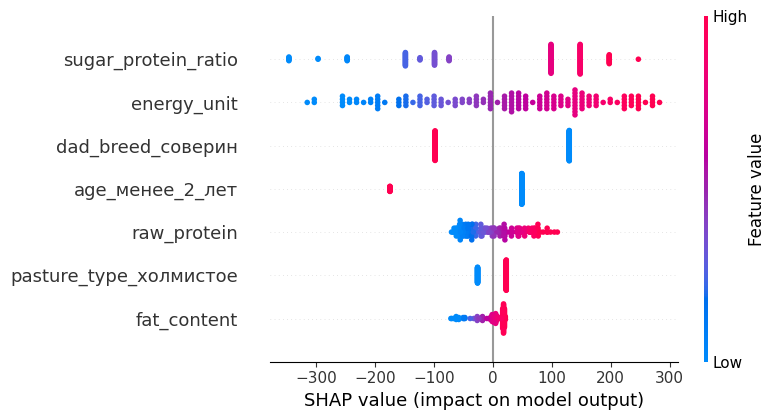

In [40]:
shap_perfomance(pipeline_reg_v1, X_train_reg_1, X_test_reg_1)

Как можно заметить, наибольшее влияние на предсказание имеют фичи ```sugar_protein_ratio```, ```energy_unit```, а наименьшее ```fat_content``` и ```pasture_type_холмистое```

*Анализ остатков*

In [41]:
analyze_residuals(pipeline_reg_v1, X_test_reg_1, y_test_reg_1, xbins_size=150)

Гистограмма симметричена относительно -15, что в рамках значений остатков близко к нулю, это хороший знак. Также плюсом является отсутсвие выбросов (нет поодаль стоящих столбиков гистограммы).

На диаграмме рассеивания можно заметить "дугу", что говорит о непостоянстве качества предсказания. Расшифровать это можно как то, что говорит о нелинейной зависимости между некоторым признаком и таргетом.

- Коэффициент детерминации (r2) ≈ 0.80 — приемлемое качество модели.
- Гистограмма остатков симметрична около нуля — систематическая ошибка отсутствует.
- Наличие "двустороннего рупора" на диаграмме рассеивания — ошибки возрастают на крайних значениях.
- Возможные причины: недостаточно признаков или их информативность недостаточна.

<hr style="border: none; border-top: 3px dashed;">

#### Версия 2

Нововведения исходя из [версии 1](#lin-reg1):
- Перевод количественной переменной ```sugar_protein_ratio``` в категориальной из-за многомодальности.
- Так как ```milk_yield``` и ```energy_unit``` связаны квадратичной функции, то возведем в квадртат ```energy_unit```, чтоб они зависели линейно.

*Собираем модель*

In [42]:
X_train_reg_2, X_test_reg_2, y_train_reg_2, y_test_reg_2 = get_reg_X_y([
    'energy_unit',
    'sugar_protein_ratio',
    'raw_protein',
    'dad_breed',
    'fat_content',
    'age',
    'pasture_type',
])

pipeline_reg_v2 = get_pipepline_reg(
    numerical_columns=X_train_reg_2.select_dtypes([int, float]).columns,
    categorical_columns=X_train_reg_2.select_dtypes(['object']).columns,
    convertible_columns={'sugar_protein_ratio': 2},
    func_transformable_columns={'energy_unit': np.square},
)
display(pipeline_reg_v2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['fat_content',
                                                   'raw_protein']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['dad_breed', 'age', 'pasture_type'], dtype='object')...
                                                                   StandardScaler(with_mean=False))]),
                                                  ['sugar_protein_ratio']),
                                                 ('func_transformable_energy_unit',
                                                  Pipeline(steps=[('func_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'square'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['energy_unit'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RFECV(cv=5, estimator=LinearRegression(n_jobs=2), n_jobs=5,
                       scoring='r2'))])

*Обучаем и выводим качество модели*

In [43]:
pipeline_reg_v2.fit(X_train_reg_2, y_train_reg_2)
print(f'r2={r2_score(y_test_reg_2, pipeline_reg_v2.predict(X_test_reg_2)):.4f}')

r2=0.8187


*Посмотрим как ведет себя модели при разных количествах параметров*

In [44]:
rfecv_perfomance(pipeline_reg_v1.named_steps['model'].cv_results_, pipeline_reg_v2.named_steps['model'].cv_results_, score_names=['r2', 'r2'])

Видно, что нововведение повлияли положительно на метрики.

*Посмотрим на вклад каждой фичи в модели*

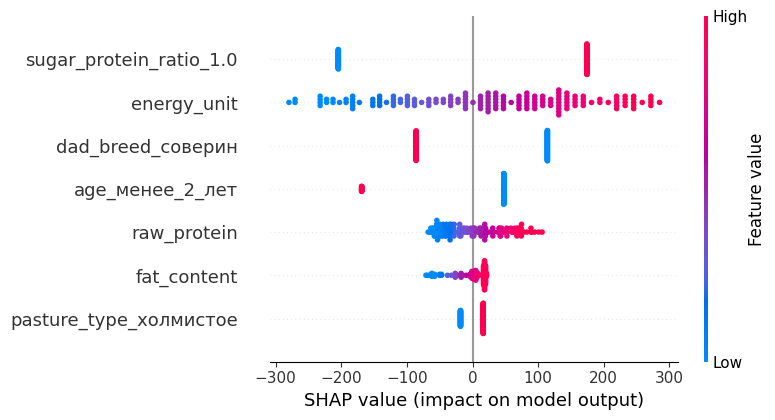

In [45]:
shap_perfomance(pipeline_reg_v2, X_train_reg_2, X_test_reg_2)

Как можно заметить, наибольшее влияние на предсказание имеют фичи ```sugar_protein_ratio_1.0``` и ```energy_unit```, а наименьшее ```milk_taste_не вкусно``` и ```fat_content```

*Анализ остатков*

In [46]:
analyze_residuals(pipeline_reg_v2, X_test_reg_2, y_test_reg_2, xbins_size=120)

Гистограмма остатков одномодальна и имееет плавный подъем и более резкий спуск. Среднее значение ошибки близко к нулю. А диапазон значений вцелом симметричен относительно середины. Модель имеет смещение влево, что значит модель завышает многие ответы.

"Двусторонний" рупор остался, значит нужны еще признаки.

- r2 улучшился до ≈ 0.82 после бинирования sugar_protein_ratio и возведения energy_unit в квадрат.
- Гистограмма остатков стала более симметричной и ближе к нормальному распределению.
- Небольшое смещение остатков влево — модель слегка завышает предсказания.
- "Двусторонний рупор" сохраняется — требуется добавить дополнительные признаки.

<hr style="border: none; border-top: 3px dashed;">

#### Версия 3

*Собираем модель*

In [47]:
X_train_reg_3, X_test_reg_3, y_train_reg_3, y_test_reg_3 = get_reg_X_y([
    'energy_unit',
    'sugar_protein_ratio',
    'raw_protein',
    'dad_breed',
    'fat_content',
    'age',
    'pasture_type',
    'dad_name'
])

pipeline_reg_v3 = get_pipepline_reg(
    numerical_columns=X_train_reg_3.select_dtypes([int, float]).columns,
    categorical_columns=X_train_reg_3.select_dtypes(['object']).columns,
    convertible_columns={'sugar_protein_ratio': 2},
    func_transformable_columns={'energy_unit': np.square},
)
display(pipeline_reg_v3)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['fat_content',
                                                   'raw_protein']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['dad_breed', 'age', 'pasture_type', 'dad_name'], dtyp...
                                                                   StandardScaler(with_mean=False))]),
                                                  ['sugar_protein_ratio']),
                                                 ('func_transformable_energy_unit',
                                                  Pipeline(steps=[('func_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'square'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['energy_unit'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RFECV(cv=5, estimator=LinearRegression(n_jobs=2), n_jobs=5,
                       scoring='r2'))])

*Обучаем и выводим качество модели*

In [48]:
pipeline_reg_v3.fit(X_train_reg_3, y_train_reg_3)
print(f'r2={r2_score(y_test_reg_3, pipeline_reg_v3.predict(X_test_reg_3)):.4f}')

r2=0.8446


*Посмотрим как ведет себя модели при разных количествах параметров*

In [49]:
rfecv_perfomance(pipeline_reg_v1.named_steps['model'].cv_results_,
                 pipeline_reg_v2.named_steps['model'].cv_results_,
                 pipeline_reg_v3.named_steps['model'].cv_results_,
                 score_names=['r2', 'r2', 'r2'])

Можно заметить, что RFECV предпочел 9 фичей, нежели 11

*Посмотрим какие же фичи он удалил*

In [50]:
set(pipeline_reg_v3.named_steps['preprocessor'].get_feature_names_out()) - set(pipeline_reg_v3.get_feature_names_out())

{'dad_breed_соверин', 'dad_name_соловчик'}

В пролете остались ```dad_breed_соверин``` и ```dad_name_соловчик```. Это может быть связано с тем, что только по определенной породе есть линейная закономерность (аналогично ```dad_name```)

Ради интереса посмотрим матрицу корреляции на обработаном пайплайном датасете.

In [51]:
px.imshow(
    pd.concat(
        [y_train_reg_3.reset_index(drop=True),
         pd.DataFrame(pipeline_reg_v3.named_steps['preprocessor'].transform(X_train_reg_3), columns=pipeline_reg_v3.named_steps['preprocessor'].get_feature_names_out())],
        axis=1).phik_matrix(), 
    text_auto='.3f',
    color_continuous_scale='oranges',
    title='Матрица корреляции для <b>ferma</b>'
).update_layout(
    width=1000,
    height=800,
    title_font_size=20,
    font=dict(size=14)
)

interval columns not set, guessing: ['milk_yield', 'fat_content', 'raw_protein', 'dad_breed_соверин', 'age_менее_2_лет', 'pasture_type_холмистое', 'dad_name_буйный', 'dad_name_геркулес', 'dad_name_соловчик', 'sugar_protein_ratio_1.0', 'energy_unit']


RFECV путем рекурсивного отбора фичей выявил ненедобность этих признака:
- С ```dad_name_соловчик``` все понятно (маленькое значение корреляции)
- А в случае ```dad_breed_соверин``` я думаю проблема с мультиколлинеарностью (к примеру с важной фичой ```dad_name_буйный```) 

*Посмотрим на вклад каждой фичи в модели*

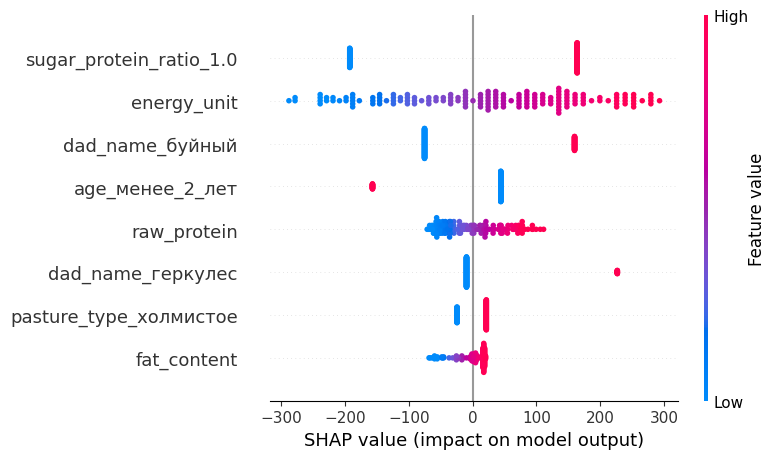

In [52]:
shap_perfomance(pipeline_reg_v3, X_train_reg_3, X_test_reg_3)

Как можно заметить, наибольшее влияние на предсказание имеют фичи ```sugar_protein_ratio_1.0``` и ```energy_unit```, а наименьшее ```milk_taste_не вкусно``` и ```fat_content```

*Анализ остатков*

In [53]:
analyze_residuals(pipeline_reg_v3, X_test_reg_3, y_test_reg_3, xbins_size=109)

Модель стала значительно лучше, потому что среднее значение остатков стало ближе к нулю и гистограмма распределения остатков больше напоминает нормальное распределение. Характерный для прошлых моделей "двусторонний" рупор остался, но теперь не так выражен.

- r2 повысился до ≈ 0.84 после добавления признака dad_name и оптимизации модели.
- Среднее значение остатков близко к нулю; гистограмма напоминает нормальное распределение.
- "Двусторонний рупор" стал менее выраженным — уменьшение ошибок на крайних значениях.
- Улучшение достигнуто благодаря включению нового признака.

<hr style="border: none; border-top: 3px dashed;">

#### Результат

*Метрики*

In [54]:
param1 = [y_test_reg_1, pipeline_reg_v1.predict(X_test_reg_1)]
param2 = [y_test_reg_2, pipeline_reg_v2.predict(X_test_reg_2)]
param3 = [y_test_reg_3, pipeline_reg_v3.predict(X_test_reg_3)]
pd.DataFrame([[r2_score(*param1), mean_squared_error(*param1), mean_absolute_error(*param1), root_mean_squared_error(*param1)],
              [r2_score(*param2), mean_squared_error(*param2), mean_absolute_error(*param2), root_mean_squared_error(*param2)],
              [r2_score(*param3), mean_squared_error(*param3), mean_absolute_error(*param3), root_mean_squared_error(*param3)]],
             columns=['r2', 'mse', 'mae', 'rmse'],
             index=['Версия 1', 'Версия 2', 'Версия 3']).style.background_gradient('Oranges').format(precision=3)

,r2,mse,mae,rmse
Версия 1,0.799,41951.982,160.335,204.822
Версия 2,0.819,37871.906,151.589,194.607
Версия 3,0.845,32455.167,141.273,180.153


*Анализ остатков*

In [55]:
analyze_residuals(pipeline_reg_v1, X_test_reg_1, y_test_reg_1, xbins_size=150)
analyze_residuals(pipeline_reg_v2, X_test_reg_2, y_test_reg_2, xbins_size=120)
analyze_residuals(pipeline_reg_v3, X_test_reg_3, y_test_reg_3, xbins_size=110)

По всем метрикам и по анализу остатков третья версия модели линейной регрессии для предсказании ```Удой,кг``` считается лучшей.

*Доверительный интервал*

In [56]:
residuals = y_test_reg_3 - pipeline_reg_v3.predict(X_test_reg_3)
go.Figure().add_trace(go.Box(
    y=residuals,
    name='',
    marker=dict(color='coral')
)).update_layout(
    title='Распределение ошибок модели',
    yaxis_title='Ошибки',
    xaxis_title='',
    width=400,
    height=500
).show()
lower_quantile = np.quantile(residuals, 0.025)
upper_quantile = np.quantile(residuals, 0.975)
print(f'Доверительный интервал: [{lower_quantile:.3f}; {upper_quantile:.3f}]')

Доверительный интервал: [-305.742; 371.148]


*Посмотрим на предсказание на тестовой выборке*

In [57]:
interested_cows['milk_yield'] = pipeline_reg_v3.predict(interested_cows[pipeline_reg_v3.feature_names_in_])
interested_cows.style.applymap(lambda _: 'background-color: red', subset=['milk_yield'])

C:\Users\bezgr\AppData\Local\Temp\ipykernel_10628\2953477328.py:2: FutureWarning:

Styler.applymap has been deprecated. Use Styler.map instead.



,breed,pasture_type,dad_breed,dad_name,fat_content,protein_content,age,energy_unit,raw_protein,sugar_protein_ratio,milk_yield
0,вис бик айдиал,холмистое,айдиал,геркулес,3.580000,3.076000,более_2_лет,15.292862,2021.280386,0.959222,6569.077022
1,вис бик айдиал,равнинное,соверин,буйный,3.540000,3.081000,менее_2_лет,15.292862,2021.280386,0.959222,6315.126228
2,рефлешнсоверинг,равнинное,соверин,барин,3.590000,3.074000,более_2_лет,15.292862,2021.280386,0.959222,6288.232595
3,рефлешнсоверинг,холмистое,айдиал,буйный,3.400000,3.061000,более_2_лет,15.292862,2021.280386,0.959222,6542.108800
4,рефлешнсоверинг,равнинное,айдиал,буйный,3.640000,3.074000,более_2_лет,15.292862,2021.280386,0.959222,6530.532547
5,рефлешнсоверинг,равнинное,соверин,геркулес,3.630000,3.053000,менее_2_лет,15.292862,2021.280386,0.959222,6329.227402
7,вис бик айдиал,равнинное,соверин,буйный,3.570000,3.079000,более_2_лет,15.292862,2021.280386,0.959222,6520.524843
9,рефлешнсоверинг,холмистое,айдиал,буйный,3.400000,3.079000,менее_2_лет,15.292862,2021.280386,0.959222,6340.999201
10,вис бик айдиал,холмистое,соверин,соловчик,3.730000,3.055000,более_2_лет,15.292862,2021.280386,0.959222,6354.136386
11,рефлешнсоверинг,равнинное,соверин,геркулес,3.730000,3.073000,более_2_лет,15.292862,2021.280386,0.959222,6544.633721


<hr style="border: none; border-top: 3px dashed;">

#### Вывод

- Пошаговое улучшение модели повысило r2 с 0.81 до 0.85.
- Преобразование признаков и добавление новых переменных улучшили качество предсказаний.
- RFECV помог определить наиболее значимые признаки и исключить менее важные.
- Остались небольшие проблемы с точностью на крайних значениях.
- Для дальнейшего улучшения рекомендуется добавить новые релевантные признаки или использовать более сложные модели.

_____
### Модель бинарной классификации для предсказания ```Вкуса молока```.

Аналогичные инструменты для удобного использования модели.
- Так как для задачи важна не условная точность предсказания, а точность предсказания молока коровы как вкусное, то метрику для валидации в RFECV по умолчанию я поставил precision, так как $preciosion = \frac{TP}{TP+FP}$ (ошибки первого рода критичнее).
- Также я выбрал метрику roc_auc, которая отражает как хорошо модель отделяет положительный класс от отрицательного на различных уровнях порога для предсказаний, что будет кстати при дальнейшей настройке трешхолда.

In [58]:
class RFECVWithEncoder(RFECV):
    def predict(self, X, decode=False):
        y_pred = super().predict(X)
        if decode:
            return pd.Series(pd.Categorical.from_codes(y_pred, categories=['не вкусно', 'вкусно'], ordered=True))
        return y_pred


def get_clf_X_y(columns) -> list[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
    X = ferma[columns]
    y = ferma.milk_taste
    return train_test_split(X, y, random_state=46)


def get_pipepline_clf(numerical_columns: list[str],
                      categorical_columns: list[str],
                      convertible_columns: dict[str, int] = dict(),
                      func_transformable_columns: dict[str, callable] = dict(),
                      score_name: str = 'precision') -> Pipeline:
    '''
    Создает пайплайн для модели классификации.

    Parameters
    ----------
    numerical_columns : list of str
        Список имен числовых колонок, которые необходимо масштабировать.
    categorical_columns : list of str
        Список имен категориальных колонок, которые необходимо закодировать.
    convertible_columns : dict of {str: int}, optional
        Словарь, где ключ — имя числовой переменной, а значение — количество бинов (n_bins),
        если требуется бинирование. Пример: {'sugar_protein_ratio': 3}.
        По умолчанию пустой словарь (бинирование не выполняется).
    func_transformable_columns : dict of {str: callable}, optional
        Словарь, где ключ — имя числовой переменной, а значение — функция для её преобразования,
        которая будет применена через FunctionTransformer. Пример: {'energy_unit': np.square}.
        По умолчанию пустой словарь (функции не применяются).
    score_name : str, optional
        Название метрики, которая будет использоваться для оценки качества
        модели при отборе признаков с помощью RFECV.По умолчанию: 'precision'.
    
    Returns
    -------
    pipeline : sklearn.pipeline.Pipeline
        Конвейер, содержащий шаги предобработки данных и обучения модели регрессии.
        Шаги включают:
        - Масштабирование числовых колонок.
        - Кодирование категориальных колонок.
        - Бинирование и кодирование числовых колонок, если указаны в convertible_columns.
        - Преобразование данных через функции, если указаны в func_transformable_columns.
        - Модель с RFECV для отбора признаков и обучения линейной регрессии.
    '''
    numerical_preprocessor = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_preprocessor = Pipeline(
        steps=[('one_hot', OneHotEncoder(handle_unknown='ignore', drop='first')),
               ('scaler', StandardScaler(with_mean=False))]
    )

    transformers = [('numerical', numerical_preprocessor, list(set(numerical_columns) - set(convertible_columns) - set(func_transformable_columns))),
                    ('categorical', categorical_preprocessor, categorical_columns)]

    for column in convertible_columns:
        convertible_preprocessor = Pipeline(
            steps=[('discretizer', KBinsDiscretizer(n_bins=convertible_columns[column], encode='ordinal', strategy='kmeans')),
                   ('one_hot', OneHotEncoder(handle_unknown='ignore', drop='first')),
                   ('scaler', StandardScaler(with_mean=False))]
        )
        transformers.append((f'convertible_{column}', convertible_preprocessor, [column]))
    
    for column in func_transformable_columns:
        func_transformable_preprocessor = Pipeline(
            steps=[('func_transform', FunctionTransformer(func_transformable_columns[column], feature_names_out='one-to-one')),
                   ('scaler', StandardScaler())]
        )
        transformers.append((f'func_transformable_{column}', func_transformable_preprocessor, [column]))

    preprocessor = ColumnTransformer(transformers, verbose_feature_names_out=False)

    return Pipeline(
        steps=[
            ('preprocessor', preprocessor),
            ('model',
             RFECVWithEncoder(estimator=LogisticRegression(n_jobs=2),
                              min_features_to_select=1,
                              step=1,
                              scoring=score_name,
                              n_jobs=5,
                              cv=5,
                              verbose=0))
        ]
    )


def confusion_matrix_and_metrics(y_test, y_pred, y_pred_proba, perfomances):
    perfomances.append([precision_score(y_test, y_pred, pos_label='вкусно') * 100,
                        recall_score(y_test, y_pred, pos_label='вкусно') * 100,
                        f1_score(y_test, y_pred, pos_label='вкусно') * 100,
                        roc_auc_score(y_test.cat.codes, y_pred_proba) * 100,
                        (2 * roc_auc_score(y_test.cat.codes, y_pred_proba) - 1) * 100,
                        accuracy_score(y_test, y_pred) * 100])
    display(pd.DataFrame(
        data=[perfomances[-1]],
        columns=['precision', 'recall', 'f1', 'roc_auc', 'gini', 'accuracy'],
        index=[f'Версия {len(perfomances)}']
    ).style.format(precision=2))
    ConfusionMatrixDisplay(
        confusion_matrix=confusion_matrix(
            y_test.cat.codes,
            y_pred.cat.codes,
        ),
        display_labels=y_test.cat.categories
    ).plot()

Так как модель логистической регрессии тоже требует линейную зависимость от таргета и признаков, то оставим предобработку признаков аналогичной.

Оставил признаки, корреляция с таргетом которых больше приемлимого.

In [59]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = get_clf_X_y([
    'energy_unit',
    'sugar_protein_ratio',
    'raw_protein',
    'pasture_type',
])

<hr style="border: none; border-top: 3px dashed;">

#### Версия 1

*Собираем модель*

In [60]:
pipeline_clf_v1 = get_pipepline_clf(
    numerical_columns=X_train_clf.select_dtypes([int, float]).columns,
    categorical_columns=X_train_clf.select_dtypes(['object']).columns,
    convertible_columns={'sugar_protein_ratio': 2},
    func_transformable_columns={'energy_unit': np.square},
    score_name='precision'
)
display(pipeline_clf_v1)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['raw_protein']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['pasture_type'], dtype='object')),
                                                 ('convertible_sugar_protein_ra...
                                                  ['sugar_protein_ratio']),
                                                 ('func_transformable_energy_unit',
                                                  Pipeline(steps=[('func_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'square'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['energy_unit'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RFECVWithEncoder(cv=5, estimator=LogisticRegression(n_jobs=2),
                                  n_jobs=5, scoring='precision'))])

*Обучение*

In [61]:
pipeline_clf_v1.fit(X_train_clf, y_train_clf.cat.codes)
print('Оставшиеся колонки:', list(pipeline_clf_v1.get_feature_names_out()))

Оставшиеся колонки: ['raw_protein', 'pasture_type_холмистое', 'sugar_protein_ratio_1.0', 'energy_unit']


*Посмотрим как ведет себя модель при разных количествах параметров*

In [62]:
rfecv_perfomance(pipeline_clf_v1.named_steps['model'].cv_results_, score_names=['precision'])

*Предскажем значения на тесотвой выборке*

In [63]:
y_pred_clf_decode_1 = pipeline_clf_v1.predict(X_test_clf, decode=True)
y_pred_clf_encode_1 = pipeline_clf_v1.predict(X_test_clf, decode=False)
y_pred_proba_clf_1 = pipeline_clf_v1.predict_proba(X_test_clf)[:, 1]

*Посмотрим на вклад каждой фичи в модели*

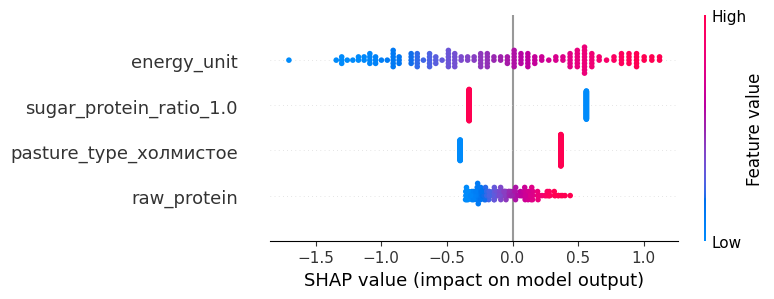

In [64]:
shap_perfomance(pipeline_clf_v1, X_train_clf, X_test_clf)

*Нарисуем матрицу ошибок и метрики данной модели*

,precision,recall,f1,roc_auc,gini,accuracy
Версия 1,71.03,75.25,73.08,66.86,33.72,64.10


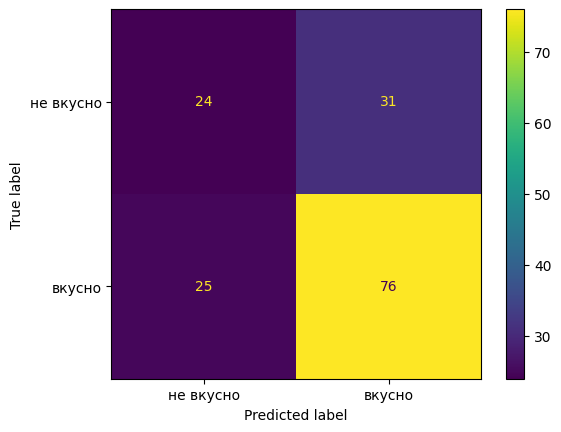

In [65]:
perfomances = []
confusion_matrix_and_metrics(y_test_clf, y_pred_clf_decode_1, y_pred_proba_clf_1, perfomances)

<hr style="border: none; border-top: 3px dashed;">

#### Версия 2

Поменяем только валидационный score для RFECV

*Собираем модель*

In [66]:
pipeline_clf_v2 = get_pipepline_clf(
    numerical_columns=X_train_clf.select_dtypes([int, float]).columns,
    categorical_columns=X_train_clf.select_dtypes(['object']).columns,
    convertible_columns={'sugar_protein_ratio': 2},
    func_transformable_columns={'energy_unit': np.square},
    score_name='roc_auc'
)
display(pipeline_clf_v2)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['raw_protein']),
                                                 ('categorical',
                                                  Pipeline(steps=[('one_hot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore')),
                                                                  ('scaler',
                                                                   StandardScaler(with_mean=False))]),
                                                  Index(['pasture_type'], dtype='object')),
                                                 ('convertible_sugar_protein_ra...
                                                                   StandardScaler(with_mean=False))]),
                                                  ['sugar_protein_ratio']),
                                                 ('func_transformable_energy_unit',
                                                  Pipeline(steps=[('func_transform',
                                                                   FunctionTransformer(feature_names_out='one-to-one',
                                                                                       func=<ufunc 'square'>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['energy_unit'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 RFECVWithEncoder(cv=5, estimator=LogisticRegression(n_jobs=2),
                                  n_jobs=5, scoring='roc_auc'))])

*Обучение*

In [67]:
pipeline_clf_v2.fit(X_train_clf, y_train_clf.cat.codes)
print('Оставшиеся колонки:', list(pipeline_clf_v2.get_feature_names_out()))

Оставшиеся колонки: ['raw_protein', 'pasture_type_холмистое', 'sugar_protein_ratio_1.0', 'energy_unit']


*Посмотрим как ведет себя модели при разных количествах параметров*

In [68]:
rfecv_perfomance(pipeline_clf_v1.named_steps['model'].cv_results_,
                 pipeline_clf_v2.named_steps['model'].cv_results_,
                 score_names=['precision', 'roc_auc'])

*Посмотрим на вклад каждой фичи в модели*

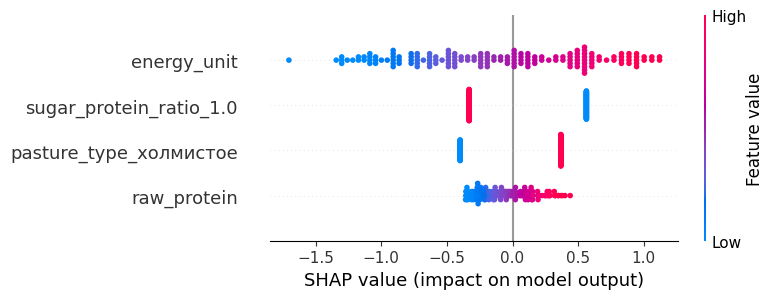

In [69]:
shap_perfomance(pipeline_clf_v2, X_train_clf, X_test_clf)

*Предскажем значения на тесотвой выборке*

In [70]:
y_pred_clf_decode_2 = pipeline_clf_v2.predict(X_test_clf, decode=True)
y_pred_clf_encode_2 = pipeline_clf_v2.predict(X_test_clf, decode=False)
y_pred_proba_clf_2 = pipeline_clf_v2.predict_proba(X_test_clf)[:, 1]

*Нарисуем матрицу ошибок и метрики данной модели*

,precision,recall,f1,roc_auc,gini,accuracy
Версия 2,71.03,75.25,73.08,66.86,33.72,64.10


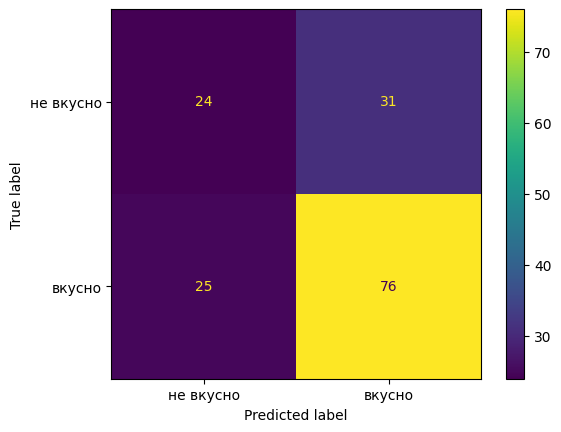

In [71]:
confusion_matrix_and_metrics(y_test_clf, y_pred_clf_decode_2, y_pred_proba_clf_2, perfomances)

<hr style="border: none; border-top: 3px dashed;">

#### Результат

In [72]:
pd.DataFrame(
    data=perfomances,
    columns=['precision', 'recall', 'f1', 'roc_auc', 'gini', 'accuracy'],
    index=[f'Версия {i}' for i in range(1, len(perfomances) + 1)]
).style.background_gradient('Oranges').format(precision=3)

,precision,recall,f1,roc_auc,gini,accuracy
Версия 1,71.028,75.248,73.077,66.859,33.717,64.103
Версия 2,71.028,75.248,73.077,66.859,33.717,64.103


- Модель с метрикой roc_auc валидацией на RFECV показывает лучшее качество на всех метриках, кроме recall (однако эта метрика не так значительна в данной задаче). Так что далее будем использовать ее.

- Повторюсь, что для задачи важнее определить точно предсказания вкуса молока как удволетворительное, поэтому поиграемся с threshold-ом на y_pred_proba_clf_2.

In [73]:
threshold_scores = []
for threshold in np.arange(0.5, 0.8, 0.005):
    threshold = round(threshold, 3)
    y_pred_th = np.where(y_pred_proba_clf_2 >= threshold, 1, 0)
    threshold_scores.append([threshold, precision_score(y_test_clf.cat.codes, y_pred_th, zero_division=0)])
pd.DataFrame(
    threshold_scores,
    columns=['th', 'precision']
).style.background_gradient('Oranges').format(precision=3)

,th,precision
0,0.500,0.710
1,0.505,0.708
2,0.510,0.705
3,0.515,0.705
4,0.520,0.725
5,0.525,0.723
6,0.530,0.714
7,0.535,0.716
8,0.540,0.714
9,0.545,0.719


Первый threshold, значение FP, при котором равно 0, равняется 0.785.

In [74]:
th_valid = lambda x: np.where(x >= 0.785, 1, 0)

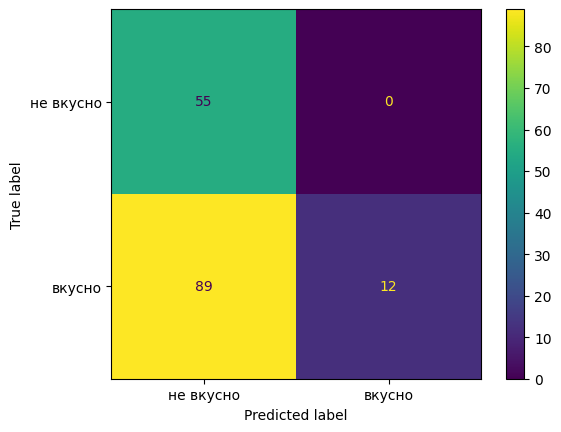

In [75]:
ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(
        y_test_clf.cat.codes,
        th_valid(y_pred_proba_clf_2),
        labels=[0, 1]
    ),
    display_labels=y_test_clf.cat.categories
).plot()

_____
_____
## Общий вывод

_____
-